# Feedforward neural network

## Import Libraries

In [13]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import scipy.stats
from keras import backend as K

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

## Load data

Caricamento dei train e test set

In [14]:
drive.mount('/content/drive', force_remount = True)
root_dir = '/content/drive/MyDrive/ProgettoAML/dataset_preprocessed/'
X_train = pd.read_csv(root_dir+'x_train_preprocessed.csv')
y_train = pd.read_csv(root_dir+'y_train_preprocessed.csv')

X_test = pd.read_csv(root_dir+'x_test_preprocessed.csv')
y_test = pd.read_csv(root_dir+'y_test_preprocessed.csv')

Mounted at /content/drive


## Model parameters

In [15]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
max_features = 20000 

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

# Weight initializer
initializer = initializers.GlorotUniform(seed=42) 

#Early stopping
callback = EarlyStopping(monitor='val_loss', patience=2)

# k-fold crossvalidation
kfold = KFold(n_splits=10, shuffle=False)

# dict for final plot
data_dict = {}
data_dict['category'] = ['Model_1','Model_2','Model_3', 'Model_4', 'Model_5']
data_dict['lower'] = []
data_dict['mean'] = []
data_dict['upper'] = []


In [16]:
def plot_history(network_history, n_epochs):
    x_plot = list(range(1,n_epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
    
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap=["#FFFFFF"], linewidths=1, linecolor="#000000")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('Predicted')
    axes.set_ylabel('Actual')
    axes.set_title("Confusion Matrix for the class - " + class_label)

## Model 1

In [ ]:
# instantiate NN model
nn_hist = []
fold_no = 0
nn_model = []

for train, test in kfold.split(X_train, y_train):

  nn_model.append(Sequential())
  nn_model[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  nn_model[fold_no].add(GlobalMaxPool1D()) # ... which will extract features from the embeddings of all words in the comment
  nn_model[fold_no].add(Dense(20, activation='relu', kernel_initializer=initializer)) # add dense layer to produce an output dimension of 50 and apply relu activation
  nn_model[fold_no].add(Dropout(0.3))
  nn_model[fold_no].add(Dense(6, activation='sigmoid'))

  nn_model[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(nn_model[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  nn_hist.append(nn_model[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2580      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 2,562,706
Trainable params: 2,562,706
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/10

History for fold 0 ...


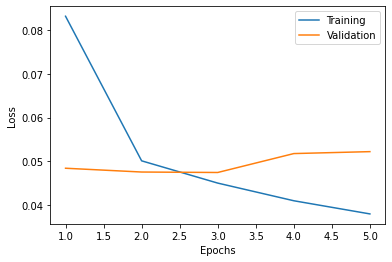

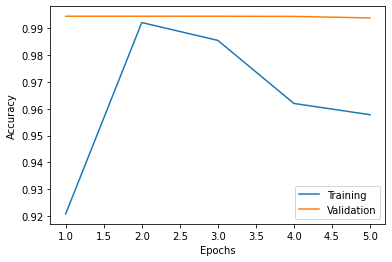

History for fold 1 ...


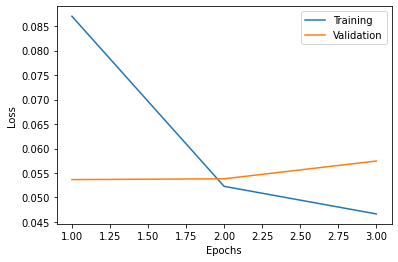

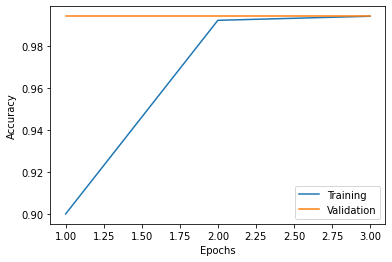

History for fold 2 ...


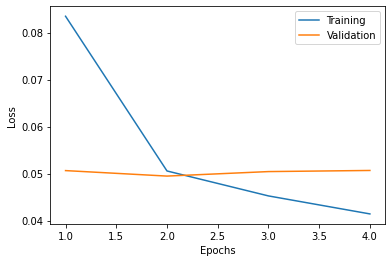

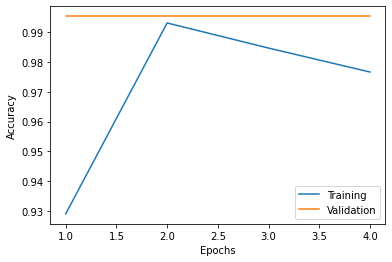

History for fold 3 ...


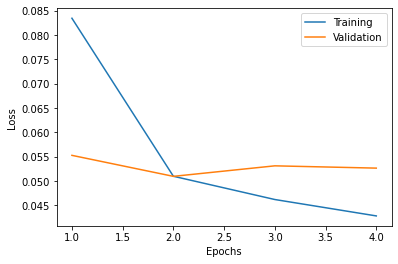

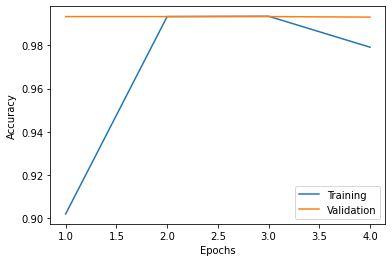

History for fold 4 ...


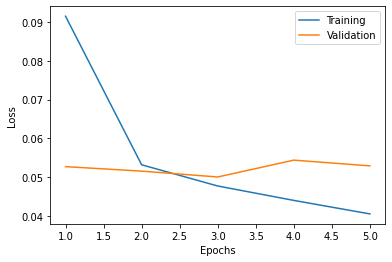

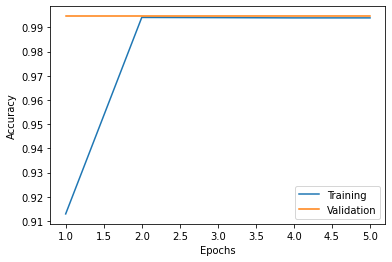

History for fold 5 ...


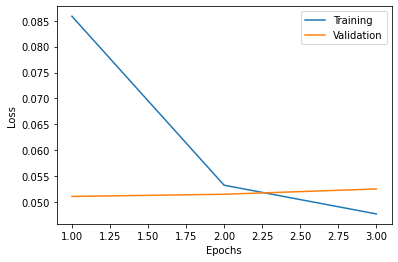

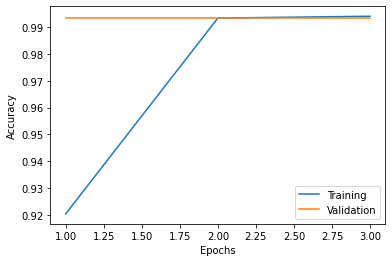

History for fold 6 ...


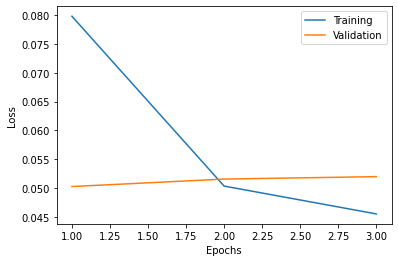

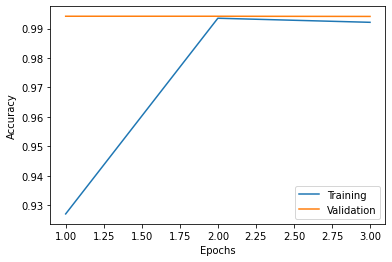

History for fold 7 ...


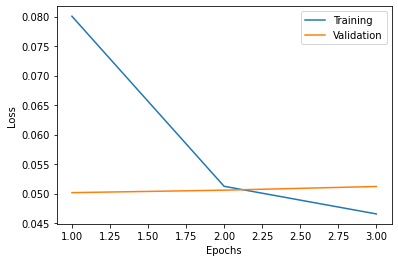

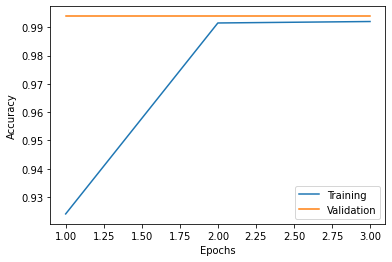

History for fold 8 ...


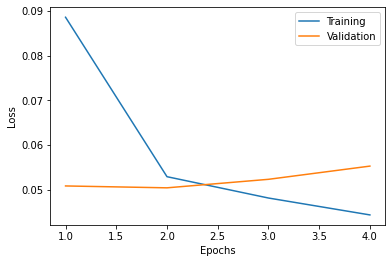

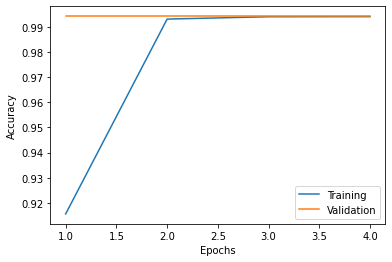

History for fold 9 ...


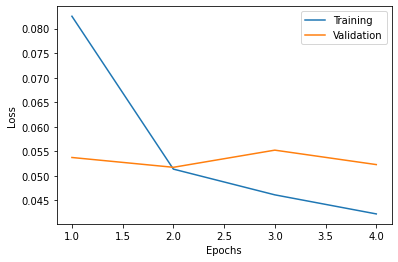

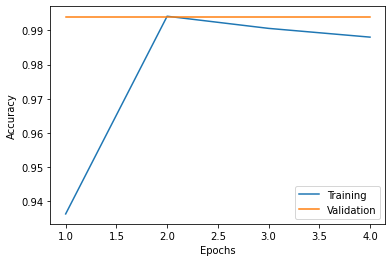

In [ ]:
for hist in range(len(nn_hist)):
  print(f'History for fold {hist} ...')
  plot_history(nn_hist[hist], len(nn_hist[hist].history['val_loss']))

In [ ]:
f1_scores_model1 = []

for fold in range(10):
  epoch =  np.argmin(nn_hist[fold].history['val_loss'], axis=0)
  f1_scores_model1.append(nn_hist[fold].history['val_f1_m'][epoch])

f1_scores_model1

[0.7311702966690063,
 0.7033697366714478,
 0.7111995220184326,
 0.699996292591095,
 0.7227269411087036,
 0.691260576248169,
 0.7147611379623413,
 0.7176746129989624,
 0.7082551121711731,
 0.7230070233345032]

## Model 2

In [ ]:
# instantiate NN model
nn_hist2 = []
fold_no = 0
nn_model2 = []

for train, test in kfold.split(X_train, y_train):

  nn_model2.append(Sequential())
  nn_model2[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  nn_model2[fold_no].add(GlobalMaxPool1D()) # ... which will extract features from the embeddings of all words in the comment
  nn_model2[fold_no].add(Dense(30, activation='relu', kernel_initializer=initializer)) # add dense layer to produce an output dimension of 50 and apply relu activation
  nn_model2[fold_no].add(Dropout(0.3))
  nn_model2[fold_no].add(Dense(6, activation='sigmoid'))

  nn_model2[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(nn_model2[fold_no].summary())

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  nn_hist2.append(nn_model2[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 30)                3870      
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 186       
Total params: 2,564,056
Trainable params: 2,564,056
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1

History for fold 0 ...


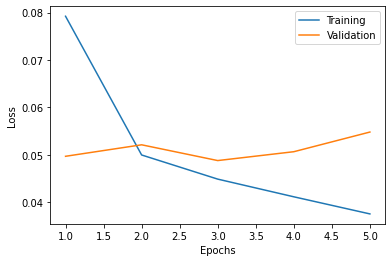

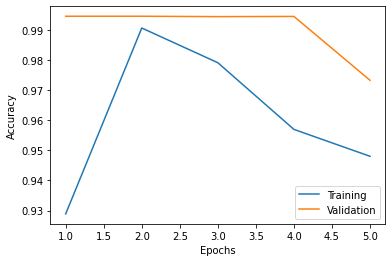

History for fold 1 ...


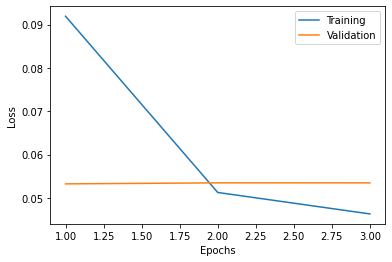

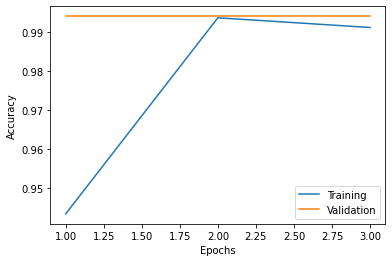

History for fold 2 ...


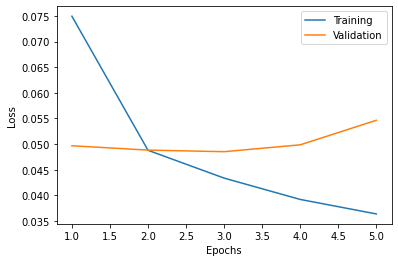

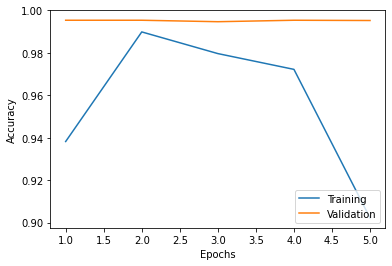

History for fold 3 ...


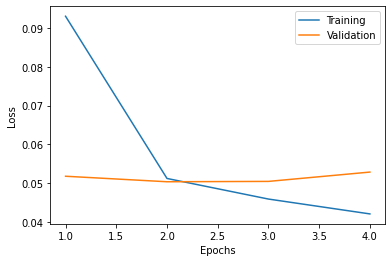

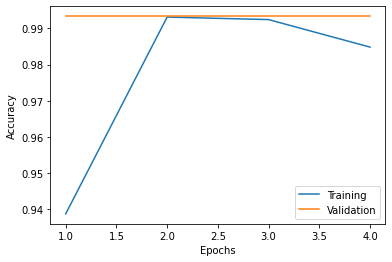

History for fold 4 ...


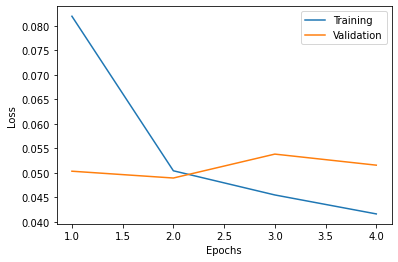

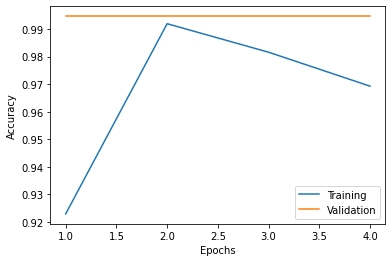

History for fold 5 ...


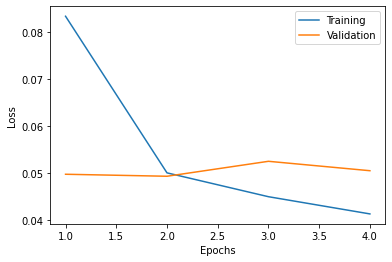

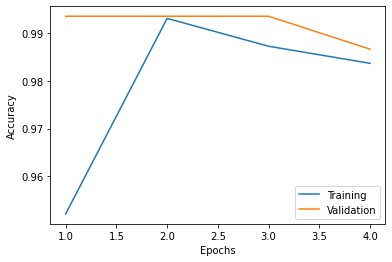

History for fold 6 ...


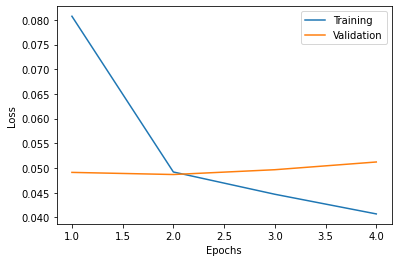

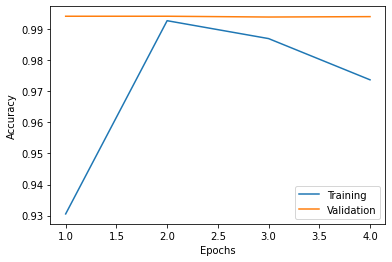

History for fold 7 ...


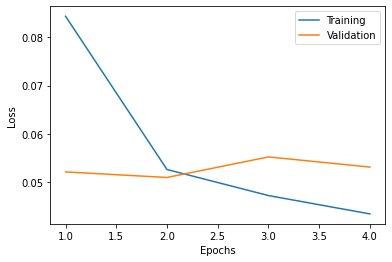

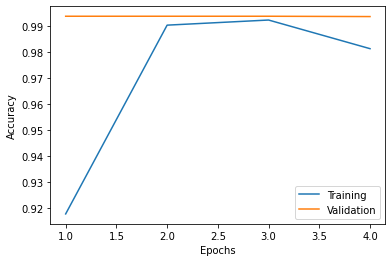

History for fold 8 ...


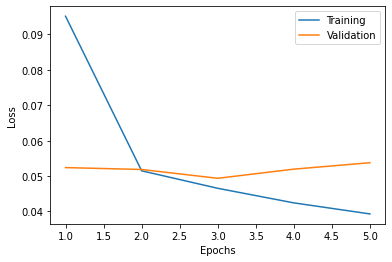

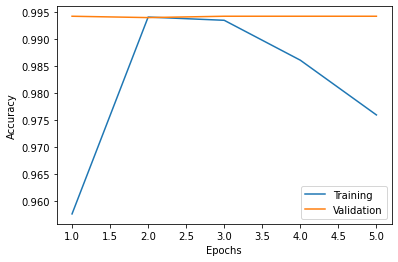

History for fold 9 ...


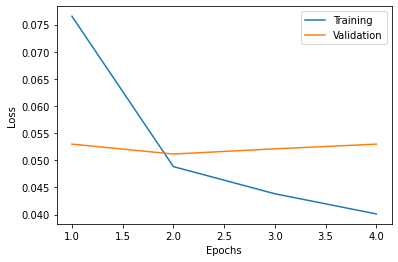

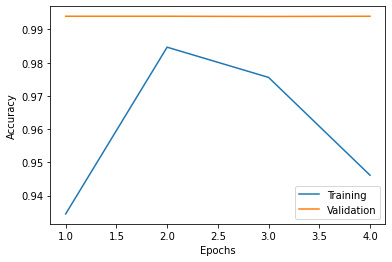

In [ ]:
for hist in range(len(nn_hist2)):
  print(f'History for fold {hist} ...')
  plot_history(nn_hist2[hist], len(nn_hist2[hist].history['val_loss']))

In [ ]:
f1_scores_model2 = []

for fold in range(10):
  epoch =  np.argmin(nn_hist2[fold].history['val_loss'], axis=0)
  f1_scores_model2.append(nn_hist2[fold].history['val_f1_m'][epoch])

f1_scores_model2

[0.7163074612617493,
 0.7061289548873901,
 0.7153508067131042,
 0.6839731335639954,
 0.7335339188575745,
 0.7204427123069763,
 0.7108480334281921,
 0.7184783816337585,
 0.7121426463127136,
 0.7350167036056519]

## Model 3

In [ ]:
# instantiate NN model
nn_hist3 = []
fold_no = 0
nn_model3 = []

for train, test in kfold.split(X_train, y_train):

  nn_model3.append(Sequential())
  nn_model3[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  nn_model3[fold_no].add(GlobalMaxPool1D()) # ... which will extract features from the embeddings of all words in the comment
  nn_model3[fold_no].add(Dense(40, activation='relu', kernel_initializer=initializer)) # add dense layer to produce an output dimension of 50 and apply relu activation
  nn_model3[fold_no].add(Dropout(0.3))
  nn_model3[fold_no].add(Dense(6, activation='sigmoid'))

  nn_model3[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(nn_model3[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  nn_hist3.append(nn_model3[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=3, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1
  

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 40)                5160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 246       
Total params: 2,565,406
Trainable params: 2,565,406
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1

History for fold 0 ...


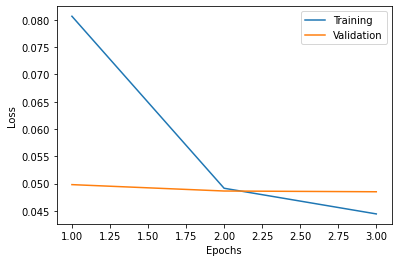

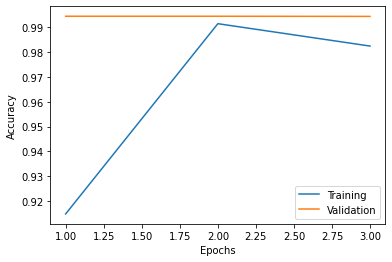

History for fold 1 ...


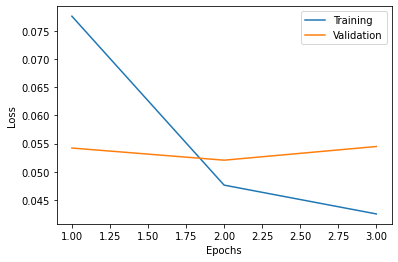

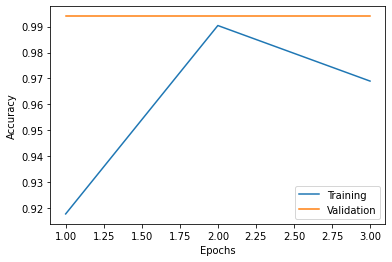

History for fold 2 ...


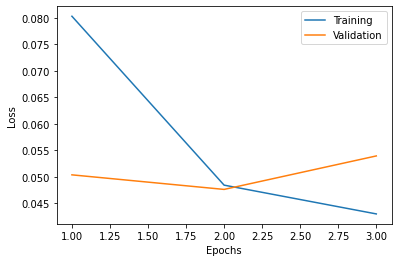

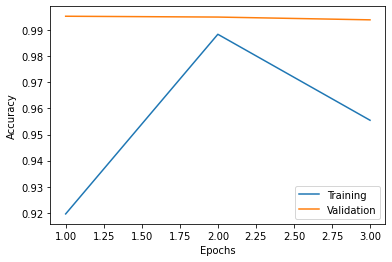

History for fold 3 ...


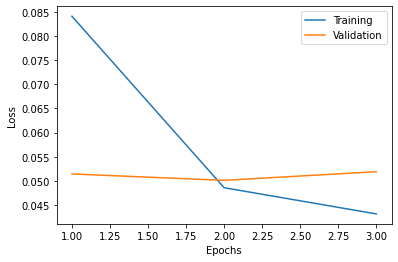

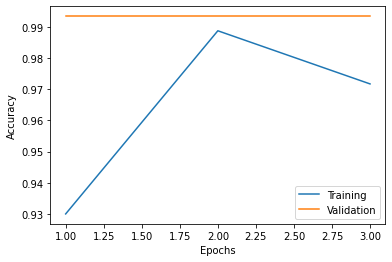

History for fold 4 ...


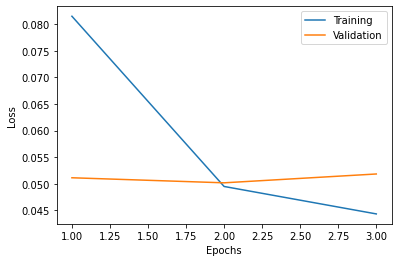

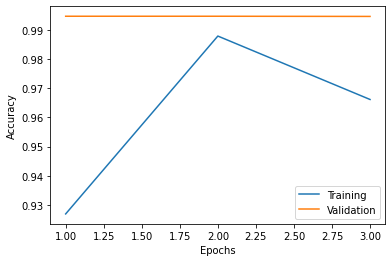

History for fold 5 ...


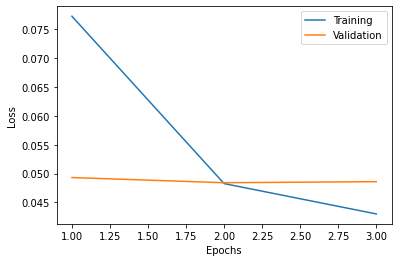

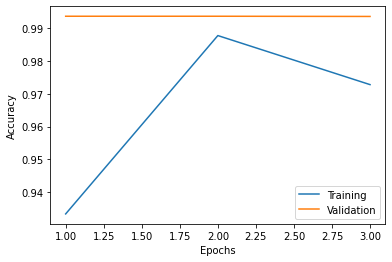

History for fold 6 ...


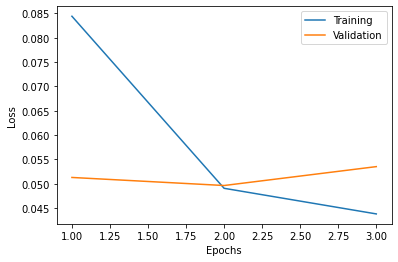

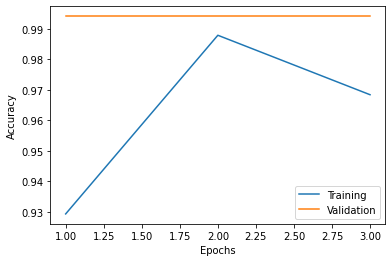

History for fold 7 ...


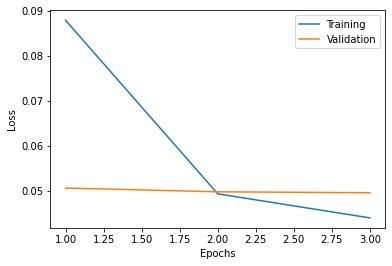

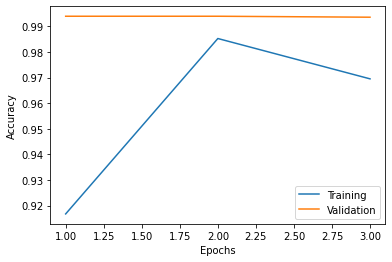

History for fold 8 ...


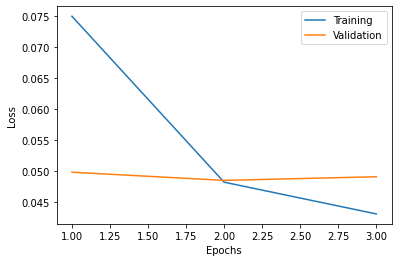

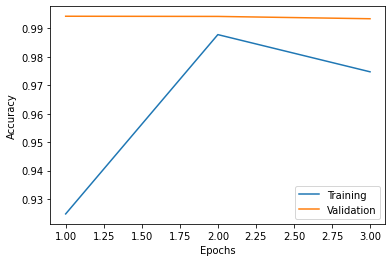

History for fold 9 ...


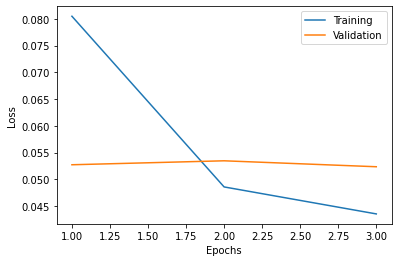

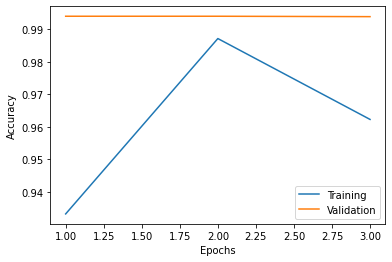

In [ ]:
for hist in range(len(nn_hist3)):
  print(f'History for fold {hist} ...')
  plot_history(nn_hist3[hist], len(nn_hist3[hist].history['val_loss']))

In [ ]:
f1_scores_model3 = []

for fold in range(10):
  epoch =  np.argmin(nn_hist3[fold].history['val_loss'], axis=0)
  f1_scores_model3.append(nn_hist3[fold].history['val_f1_m'][epoch])

f1_scores_model3

[0.7298812866210938,
 0.7151217460632324,
 0.723731279373169,
 0.7150991559028625,
 0.7110388875007629,
 0.7298057675361633,
 0.7003942131996155,
 0.7094831466674805,
 0.7171464562416077,
 0.6815387010574341]

## Model 4

In [ ]:
# instantiate NN model
nn_hist4 = []
fold_no = 0
nn_model4 = []

for train, test in kfold.split(X_train, y_train):

  nn_model4.append(Sequential())
  nn_model4[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  nn_model4[fold_no].add(GlobalMaxPool1D()) # ... which will extract features from the embeddings of all words in the comment
  nn_model4[fold_no].add(Dense(50, activation='relu', kernel_initializer=initializer)) # add dense layer to produce an output dimension of 50 and apply relu activation
  nn_model4[fold_no].add(Dropout(0.3))
  nn_model4[fold_no].add(Dense(6, activation='sigmoid'))

  nn_model4[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(nn_model4[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  nn_hist4.append(nn_model4[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_63 (Glo (None, 128)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 50)                6450      
_________________________________________________________________
dropout_83 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 6)                 306       
Total params: 2,566,756
Trainable params: 2,566,756
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1

History for fold 0 ...


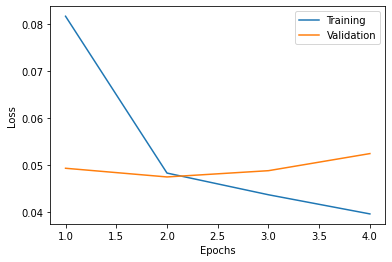

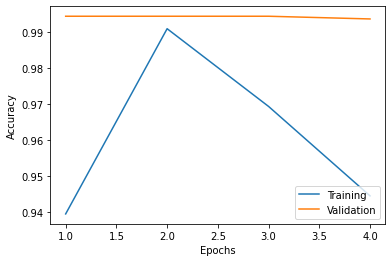

History for fold 1 ...


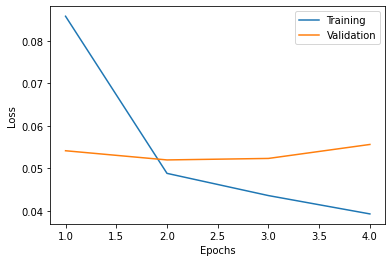

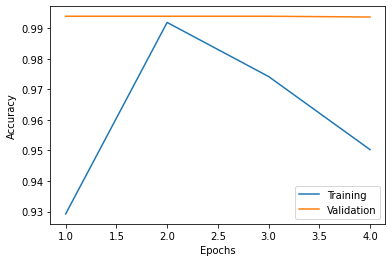

History for fold 2 ...


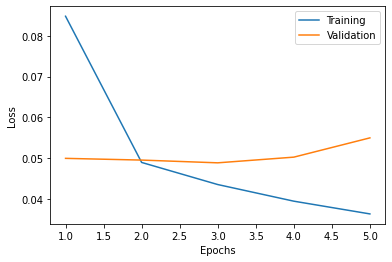

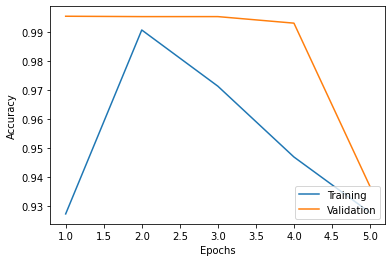

History for fold 3 ...


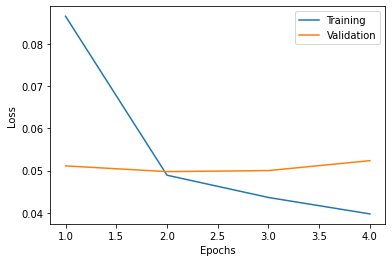

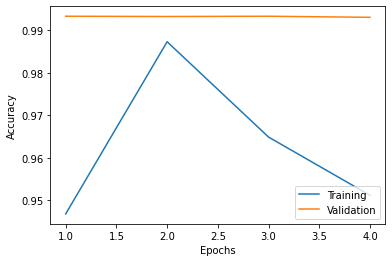

History for fold 4 ...


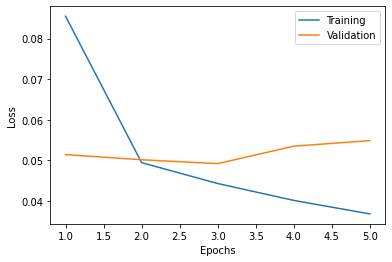

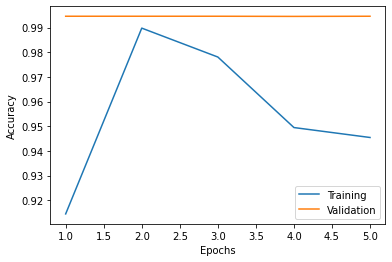

History for fold 5 ...


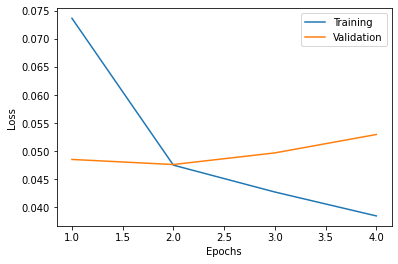

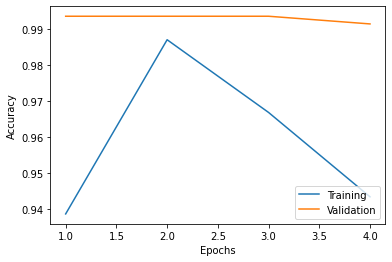

History for fold 6 ...


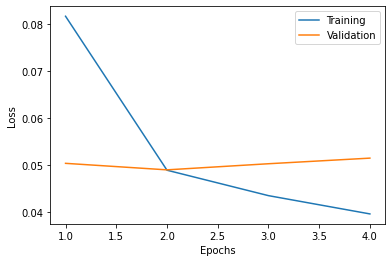

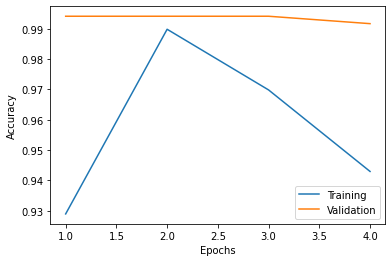

History for fold 7 ...


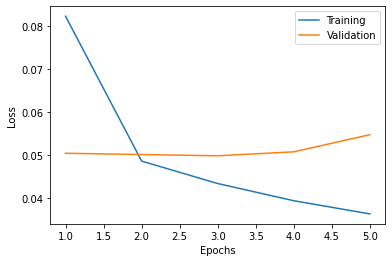

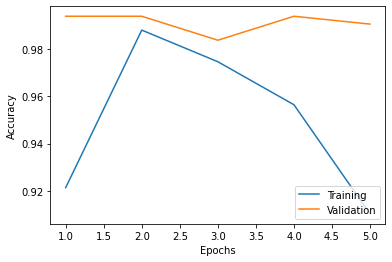

History for fold 8 ...


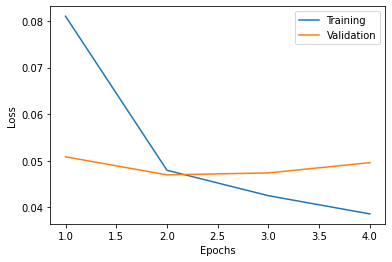

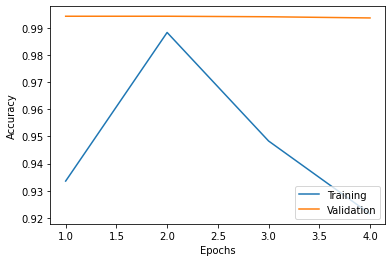

History for fold 9 ...


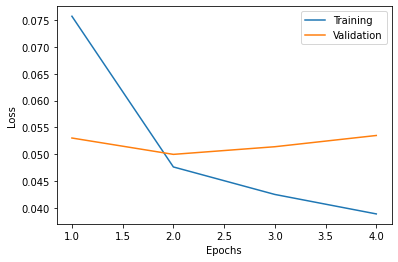

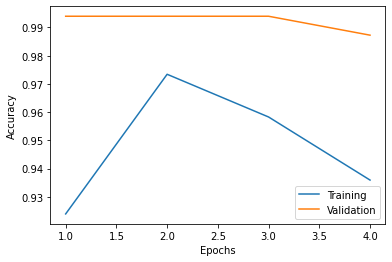

In [ ]:
for hist in range(len(nn_hist4)):
  print(f'History for fold {hist} ...')
  plot_history(nn_hist4[hist], len(nn_hist4[hist].history['val_loss']))

In [ ]:
f1_scores_model4 = []

for fold in range(10):
  epoch =  np.argmin(nn_hist4[fold].history['val_loss'], axis=0)
  f1_scores_model4.append(nn_hist4[fold].history['val_f1_m'][epoch])

f1_scores_model4

[0.7013931274414062,
 0.6988945007324219,
 0.7332836985588074,
 0.7087542414665222,
 0.7237421274185181,
 0.7209833264350891,
 0.7192177772521973,
 0.7259615659713745,
 0.7231610417366028,
 0.7238484621047974]

## Model 5

In [ ]:
# instantiate NN model
nn_hist5 = []
fold_no = 0
nn_model5 = []

for train, test in kfold.split(X_train, y_train):

  nn_model5.append(Sequential())
  nn_model5[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  nn_model5[fold_no].add(GlobalMaxPool1D()) # ... which will extract features from the embeddings of all words in the comment
  nn_model5[fold_no].add(Dense(40, activation='relu', kernel_initializer=initializer)) # add dense layer to produce an output dimension of 50 and apply relu activation
  nn_model5[fold_no].add(Dropout(0.3))
  nn_model5[fold_no].add(Dense(20, activation='relu', kernel_initializer=initializer)) # add dense layer to produce an output dimension of 50 and apply relu activation
  nn_model5[fold_no].add(Dropout(0.3))
  nn_model5[fold_no].add(Dense(6, activation='sigmoid'))

  nn_model5[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(nn_model5[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  nn_hist5.append(nn_model5[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback))
  fold_no = fold_no + 1

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_53 (Glo (None, 128)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 40)                5160      
_________________________________________________________________
dropout_63 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 20)                820       
_________________________________________________________________
dropout_64 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 6)               

History for fold 0 ...


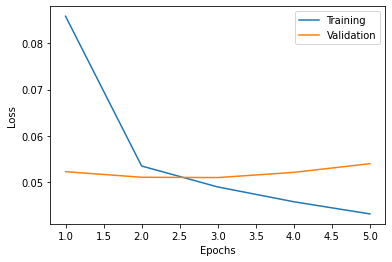

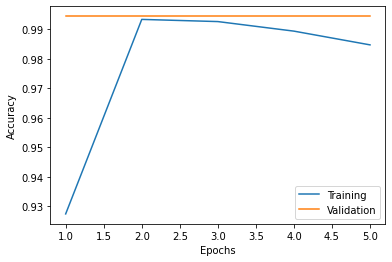

History for fold 1 ...


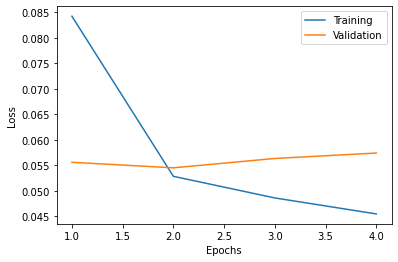

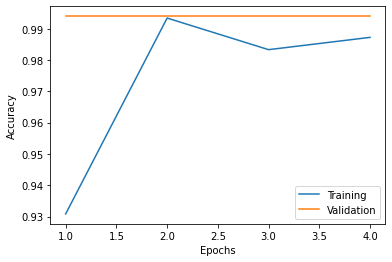

History for fold 2 ...


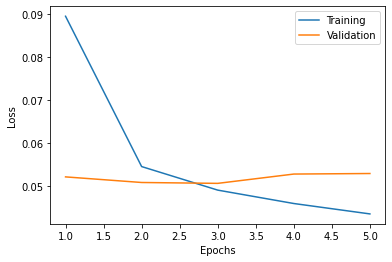

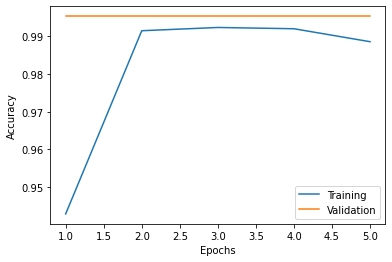

History for fold 3 ...


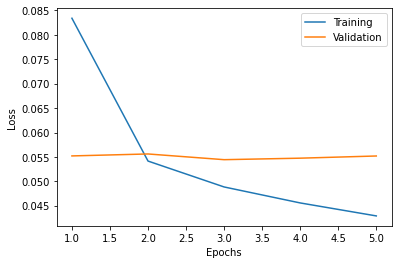

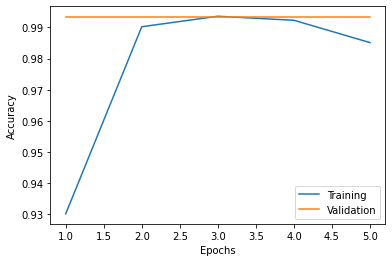

History for fold 4 ...


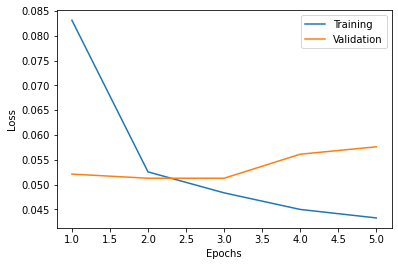

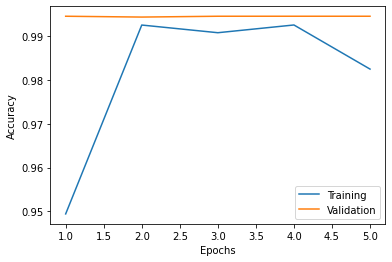

History for fold 5 ...


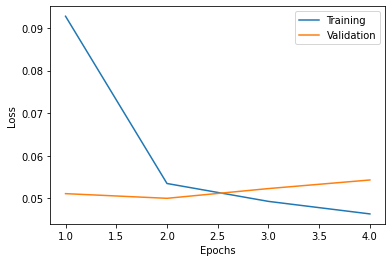

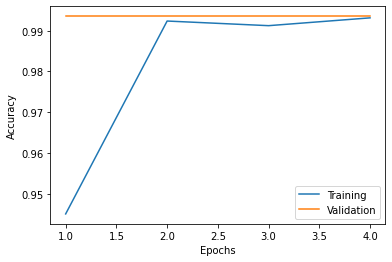

History for fold 6 ...


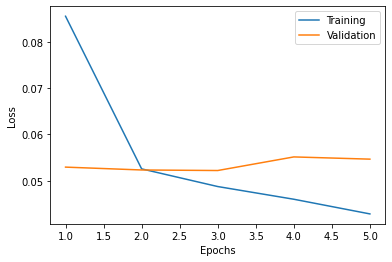

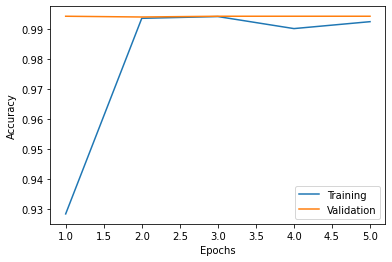

History for fold 7 ...


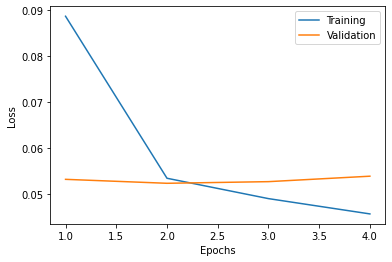

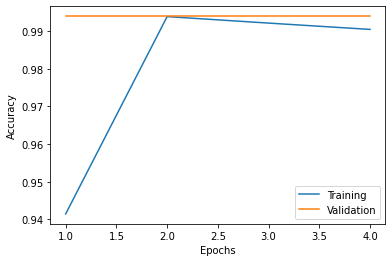

History for fold 8 ...


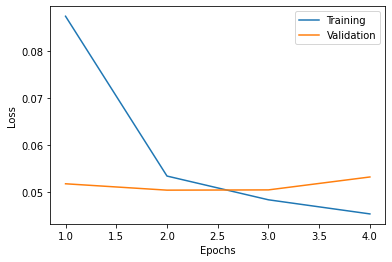

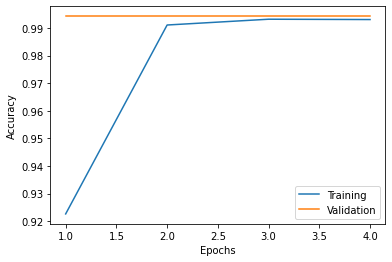

History for fold 9 ...


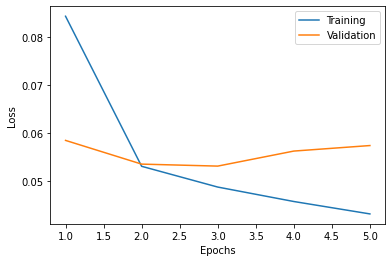

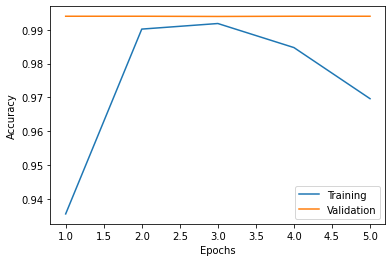

In [ ]:
for hist in range(len(nn_hist5)):
  print(f'History for fold {hist} ...')
  plot_history(nn_hist5[hist], len(nn_hist5[hist].history['val_loss']))


In [ ]:
f1_scores_model5 = []

for fold in range(10):
  epoch =  np.argmin(nn_hist5[fold].history['val_loss'], axis=0)
  f1_scores_model5.append(nn_hist5[fold].history['val_f1_m'][epoch])

f1_scores_model5

[0.7079654932022095,
 0.6985542178153992,
 0.7213672995567322,
 0.7090954780578613,
 0.7268323302268982,
 0.7271987199783325,
 0.7094638347625732,
 0.7159020304679871,
 0.701682448387146,
 0.7128480672836304]

# Best model selection

In [ ]:
scores = [f1_scores_model1, f1_scores_model2,f1_scores_model3, f1_scores_model4, f1_scores_model5]
for score in scores:
  mean, min,max = mean_confidence_interval(score)
  data_dict['lower'].append(min)
  data_dict['mean'].append(mean)
  data_dict['upper'].append(max)

data_dict

{'category': ['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5'],
 'lower': [0.7037256592270387,
  0.7049549708417118,
  0.703005506293664,
  0.7099174961930674,
  0.7060934248536304],
 'mean': [0.7123421251773834,
  0.7152222752571106,
  0.7133240640163422,
  0.7179239869117737,
  0.7130909919738769],
 'upper': [0.7209585911277281,
  0.7254895796725094,
  0.7236426217390204,
  0.72593047763048,
  0.7200885590941235]}

([<matplotlib.axis.YTick at 0x7fc331b8cb38>,
 [Text(0, 0, 'Model_1'),
  Text(0, 0, 'Model_2'),
  Text(0, 0, 'Model_3'),
  Text(0, 0, 'Model_4'),
  Text(0, 0, 'Model_5')])

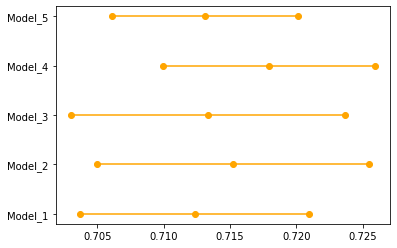

In [ ]:
dataset = pd.DataFrame(data_dict)
for lower,mean,upper,y in zip(dataset['lower'],dataset['mean'], dataset['upper'], range(len(dataset))):
    plt.plot((lower,mean,upper),(y,y,y),'ro-',color='orange')
plt.yticks(range(len(dataset)),list(dataset['category']))

# Best model evaluation on test set

In [17]:
  best_nn_model = Sequential()
  best_nn_model.add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  best_nn_model.add(GlobalMaxPool1D()) # ... which will extract features from the embeddings of all words in the comment
  best_nn_model.add(Dense(50, activation='relu', kernel_initializer=initializer)) # add dense layer to produce an output dimension of 50 and apply relu activation
  best_nn_model.add(Dropout(0.3))
  best_nn_model.add(Dense(6, activation='sigmoid'))

  best_nn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])


In [18]:
network_history = best_nn_model.fit(X_train, y_train, batch_size=256, 
                            epochs=10, verbose=2, validation_split=0.2, callbacks=callback)

Epoch 1/10
499/499 - 18s - loss: 0.0780 - accuracy: 0.9262 - f1_m: 0.5362 - val_loss: 0.0517 - val_accuracy: 0.9941 - val_f1_m: 0.7225
Epoch 2/10
499/499 - 17s - loss: 0.0472 - accuracy: 0.9878 - f1_m: 0.7266 - val_loss: 0.0491 - val_accuracy: 0.9941 - val_f1_m: 0.7187
Epoch 3/10
499/499 - 17s - loss: 0.0417 - accuracy: 0.9743 - f1_m: 0.7525 - val_loss: 0.0493 - val_accuracy: 0.9941 - val_f1_m: 0.7346
Epoch 4/10
499/499 - 17s - loss: 0.0373 - accuracy: 0.9432 - f1_m: 0.7803 - val_loss: 0.0529 - val_accuracy: 0.9940 - val_f1_m: 0.7267


In [19]:
y_pred =  best_nn_model.predict(X_test) > 0.5
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

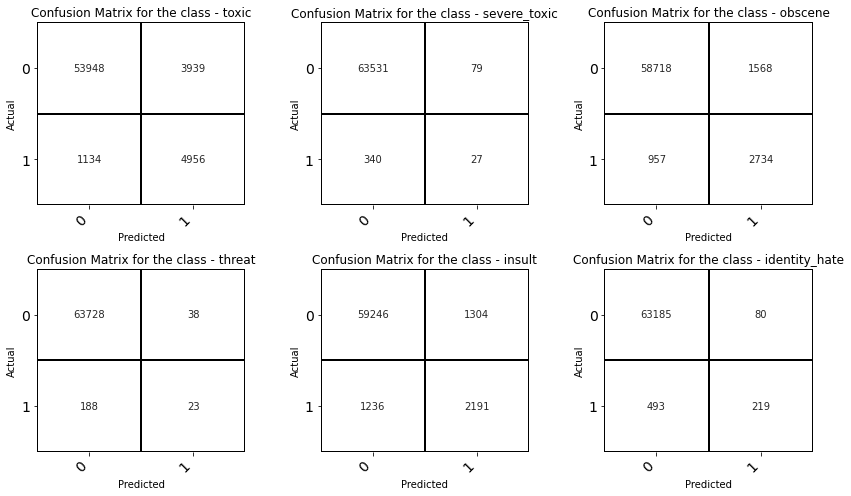

In [20]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()  

In [9]:
y_pred =  best_nn_model.predict(X_test)
score = best_nn_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
y_pred =  best_nn_model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred, zero_division=1))

Test loss: 0.07246855646371841
Test accuracy: 0.9949826002120972
              precision    recall  f1-score   support

           0       0.59      0.79      0.67      6090
           1       0.39      0.32      0.35       367
           2       0.67      0.72      0.69      3691
           3       0.37      0.10      0.16       211
           4       0.63      0.63      0.63      3427
           5       0.75      0.12      0.21       712

   micro avg       0.61      0.68      0.64     14498
   macro avg       0.56      0.45      0.45     14498
weighted avg       0.62      0.68      0.63     14498
 samples avg       0.94      0.97      0.91     14498

